In [31]:
#%pylab inline

# sets backend to render higher res images
#%matplotlib InlineBackend.figure_formats = ['retina']

import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score
import xgboost as xgb

sns.set_style("whitegrid")

In [32]:
from importlib import reload
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, accuracy_score

# %config InlineBackend.figure_formats = ['svg']
# %matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)
import matplotlib.cm as cm
import random

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sqlalchemy import create_engine
import pandas as pd
from sklearn.model_selection import train_test_split

In [33]:
df = pd.read_csv('Spotify Data/data-clean.csv')

#drop track, artist, track_id 
df = df.drop(['track', 'artist', 'track_id'], axis=1)

df.head(2)

,time_signature,chorus_hit,sections,target,popularity,sm_target,tiktok,spotify,duration_ms,danceability,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,era,main_parent_genre
0,3.0,32.94975,9.0,1.0,NaN,0.0,0,1,173533.0,0.417,...,-7.727,major,0.0403,0.490,0.000,0.0779,0.845,185.655,60s,Blues and Jazz
1,4.0,48.82510,10.0,0.0,NaN,0.0,0,1,213613.0,0.498,...,-12.475,major,0.0337,0.018,0.107,0.1760,0.797,101.801,60s,Rock


In [34]:
df.columns = map(str.lower, df.columns)
df['track_seconds'] = df['duration_ms'] / 1000
df.columns
df.shape

(40560, 23)

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import learning_curve


In [36]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (7,5), fontsize=10):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=(7,5))
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="mako") #mako
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    plt.ylabel('True label',fontsize=14)
    plt.xlabel('Predicted label',fontsize=14)
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.tight_layout()
    plt.savefig("xg_confmatrix.png")
    plt.show()
    return fig


In [37]:
# Establishing X and y
# df = df.drop(columns = ['duration_ms', 'mode', 'key', 'era', 'main_parent_genre', 'sm_target', 'tiktok','spotify'  ])


# y = df['target']
# X = df.drop(columns = ['target'])

# # Train test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# X2_train, X2_test,  y2_train,y2_test = train_test_split(X_train,y_train, test_size = 0.25, random_state = 42)

# #historgram of values of y and show it
# X.shape
from sklearn.impute import SimpleImputer

df = df.drop(columns=['duration_ms', 'mode', 'key', 'era', 'main_parent_genre', 'sm_target', 'tiktok', 'spotify'])

y = df['target']
X = df.drop(columns=['target'])

print(X.info())

# Handling missing values
imputer = SimpleImputer(strategy='mean')  # Replace missing values with the mean
X = imputer.fit_transform(X)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X2_train, X2_test, y2_train, y2_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Print the shape of X to verify the fix
print(X.shape)

#print list of features of X_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40560 entries, 0 to 40559
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time_signature    40560 non-null  float64
 1   chorus_hit        40560 non-null  float64
 2   sections          40560 non-null  float64
 3   popularity        312 non-null    float64
 4   danceability      40560 non-null  float64
 5   energy            40560 non-null  float64
 6   loudness          40560 non-null  float64
 7   speechiness       40560 non-null  float64
 8   acousticness      40560 non-null  float64
 9   instrumentalness  40560 non-null  float64
 10  liveness          40560 non-null  float64
 11  valence           40560 non-null  float64
 12  tempo             40560 non-null  float64
 13  track_seconds     40560 non-null  float64
dtypes: float64(14)
memory usage: 4.3 MB
None
(40560, 14)


In [38]:
import pandas as pd
import numpy as np
import matplotlib
#matplotlib.use('Agg')
import pylab
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
import itertools

In [39]:
# #Function used to plot the learning curve, roc curve, and confusing matrix for the given model
# import matplotlib.pyplot as plt

# def plot_model(model, X, y , X2, y2,threshold=0.5):
#     model.fit(X, y)
#     y_predict = model.predict(X)
#     #y_predictprob = model.predict_proba(X)[:, 1]
    
#     y_predictprob = (model.predict_proba(X)[:, 1] >=threshold).astype('int')

#     LR_acc = np.round(np.mean(cross_val_score(model, X, y, scoring = 'accuracy', cv = 5)), 5)
#     LR_f1 = np.round(np.mean(cross_val_score(model, X, y, scoring = 'f1', cv = 5)), 5)
#     LR_prec = np.round(np.mean(cross_val_score(model, X, y, scoring = 'precision', cv = 5)), 5)
#     LR_recall = np.round(np.mean(cross_val_score(model, X, y, scoring = 'recall', cv = 5)), 5)
#     print(f'The base LR accuracy is: {LR_acc}')
#     print(f'The base LR f1 is: {LR_f1}')
#     print(f'The base LR precision is: {LR_prec}')
#     print(f'The base LR recall is: {LR_recall}')

#     #print("train : all metrics:", metrics.classification_report(y,y_predictprob))

#     print("Precision: {:6.4f},   Recall: {:6.4f}, Accuracy: {:6.4f}".format(precision_score(y, y_predictprob),
#                                                         recall_score(y, y_predictprob) ,
#                                                         accuracy_score(y,y_predictprob)))
    
    
#     m, train_err, test_err = learning_curve(model, X, y, cv = 5, scoring = 'f1', random_state = 42)
#     m_trainerr = np.mean(train_err, axis = 1)
#     m_testerr = np.mean(test_err, axis = 1)

#     print("train error", m_trainerr.mean(), "test error", m_testerr.mean())
#     print("y pred proba ",y_predictprob)
    
    
#     # try
    
#     ns2_probs = [0 for _ in range(len(y2))]
#     y2_predict = model.predict(X2)
#     y2_predictprobs = model.predict_proba(X2)[:, 1]
#     y2_predictprob = (model.predict_proba(X2)[:, 1]>=threshold).astype('int')
    
#     #print("test : all metrics: ", metrics.classification_report(y2,y2_predictprob))    
#     print("Precision: {:6.4f},   Recall: {:6.4f}, Accuracy: {:6.4f}, f1: {:6.4f}".format(precision_score(y2, y2_predictprob),
#                                                         recall_score(y2, y2_predictprob) ,
#                                                         accuracy_score(y2,y2_predictprob),
#                                                         f1_score(y2,y2_predictprob)))
    
    
#     '''
#     connect predictions with outputs for sample probablity
#     '''
#     global y_pred_prob_df 
#     global y_pred_df
#     y3_predictprob = (model.predict_proba(X2)[:, 1]) 
    
# #     print("X inputs: ", X2[:10], type(X2))
# #     print("y predicted prob: ", y3_predictprob[:10], type(y3_predictprob))
# #     print("y predicted outcomes: ", y2_predictprob[:10], type(y2_predictprob))
# #     print("y actuals: ",y2[:10] , type(y2))
    
#     y_pred_prob_df = pd.DataFrame(y3_predictprob,columns=['y_pred_prob'])
#     y_pred_df = pd.DataFrame(y2_predictprob,columns=['y_pred'])    
    
#     '''
#     change array and series to df
#     '''
    
#     fpr, tpr, thr = roc_curve(y2, y2_predictprobs)
    
#     ns2_auc = roc_auc_score(y2, ns2_probs)
#     ns2_fpr, ns2_tpr, _ = roc_curve(y2, ns2_probs)

# #     optimal_idx = np.argmax(tpr - fpr)
# #     optimal_threshold = thresholds[optimal_idx]
# #     print("optimal idx", optimal_idx, "optimal threshold", optimal_threshold)
    
#     plt.rcParams.update({'figure.figsize': (7, 5)})
# #     plt.subplot(1,2,1)
# #     plt.plot(m, m_trainerr, 'k', m, m_testerr, 'r')
# #     plt.xlabel('Number of Samples', fontsize = 10)
# #     plt.ylabel('F1', fontsize = 10)
# #     plt.legend(['Training Error', 'Test Error'])
#     #plt.subplot(1,2,2)
    
#     plt.plot(fpr, tpr)
#     plt.xlabel('1 - Specificity (FPR)')
#     plt.ylabel('Sensitivity (TPR)');
#     plt.title(f"Area Under the ROC Curve: {np.round(roc_auc_score(y2, y2_predictprobs), 4)}");

#     print(f'AUC: {np.round(roc_auc_score(y2, y2_predictprobs), 4)}')


#     pyplot.plot(ns2_fpr, ns2_tpr, linestyle='--', label='No Skill')
#     plt.tight_layout()
#     plt.savefig("xg_aucroc.pdf")
    
    
#     conf_mat = confusion_matrix(y2, y2_predictprob)
#     cm = print_confusion_matrix(conf_mat, ['not a hit', 'is a hit'])
    
#     return y_pred_prob_df, y_pred_df

def plot_model(model, X, y, X2, y2, threshold=0.5):
    model.fit(X, y)
    y_predict = model.predict(X)
    
    y_predictprob = (model.predict_proba(X)[:, 1] >= threshold).astype('int')

    LR_acc = np.round(np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=5)), 5)
    LR_f1 = np.round(np.mean(cross_val_score(model, X, y, scoring='f1', cv=5)), 5)
    LR_prec = np.round(np.mean(cross_val_score(model, X, y, scoring='precision', cv=5)), 5)
    LR_recall = np.round(np.mean(cross_val_score(model, X, y, scoring='recall', cv=5)), 5)
    print(f'The base LR accuracy is: {LR_acc}')
    print(f'The base LR f1 is: {LR_f1}')
    print(f'The base LR precision is: {LR_prec}')
    print(f'The base LR recall is: {LR_recall}')

    print("Precision: {:6.4f}, Recall: {:6.4f}, Accuracy: {:6.4f}".format(
        precision_score(y, y_predictprob),
        recall_score(y, y_predictprob),
        accuracy_score(y, y_predictprob)
    ))
    
    m, train_err, test_err = learning_curve(model, X, y, cv=5, scoring='f1', random_state=42)
    m_trainerr = np.mean(train_err, axis=1)
    m_testerr = np.mean(test_err, axis=1)

    print("train error", m_trainerr.mean(), "test error", m_testerr.mean())
    print("y pred proba ", y_predictprob)
    
    ns2_probs = [0 for _ in range(len(y2))]
    y2_predict = model.predict(X2)
    y2_predictprobs = model.predict_proba(X2)[:, 1]
    y2_predictprob = (model.predict_proba(X2)[:, 1] >= threshold).astype('int')
    
    print("Precision: {:6.4f}, Recall: {:6.4f}, Accuracy: {:6.4f}, f1: {:6.4f}".format(
        precision_score(y2, y2_predictprob),
        recall_score(y2, y2_predictprob),
        accuracy_score(y2, y2_predictprob),
        f1_score(y2, y2_predictprob)
    ))
    
    global y_pred_prob_df
    global y_pred_df
    y3_predictprob = (model.predict_proba(X2)[:, 1]) 
    
    y_pred_prob_df = pd.DataFrame(y3_predictprob, columns=['y_pred_prob'])
    y_pred_df = pd.DataFrame(y2_predictprob, columns=['y_pred'])
    
    fpr, tpr, thr = roc_curve(y2, y2_predictprobs)
    
    ns2_auc = roc_auc_score(y2, ns2_probs)
    ns2_fpr, ns2_tpr, _ = roc_curve(y2, ns2_probs)

    plt.rcParams.update({'figure.figsize': (7, 5)})
    
    plt.plot(fpr, tpr)
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)')
    plt.title(f"Area Under the ROC Curve: {np.round(roc_auc_score(y2, y2_predictprobs), 4)}")

    print(f'AUC: {np.round(roc_auc_score(y2, y2_predictprobs), 4)}')

    plt.plot(ns2_fpr, ns2_tpr, linestyle='--', label='No Skill')
    plt.tight_layout()
    plt.savefig("xg_aucroc.pdf")
    
    conf_mat = confusion_matrix(y2, y2_predictprob)
    cm = print_confusion_matrix(conf_mat, ['not a hit', 'is a hit'])
    
    return y_pred_prob_df, y_pred_df

The base LR accuracy is: 0.76956
The base LR f1 is: 0.78239
The base LR precision is: 0.73138
The base LR recall is: 0.84118
Precision: 0.7388, Recall: 0.8502, Accuracy: 0.7781
train error 0.8089718602501568 test error 0.7781087329392935
y pred proba  [1 0 0 ... 1 0 0]
Precision: 0.7463, Recall: 0.8475, Accuracy: 0.7813, f1: 0.7937
AUC: 0.8591


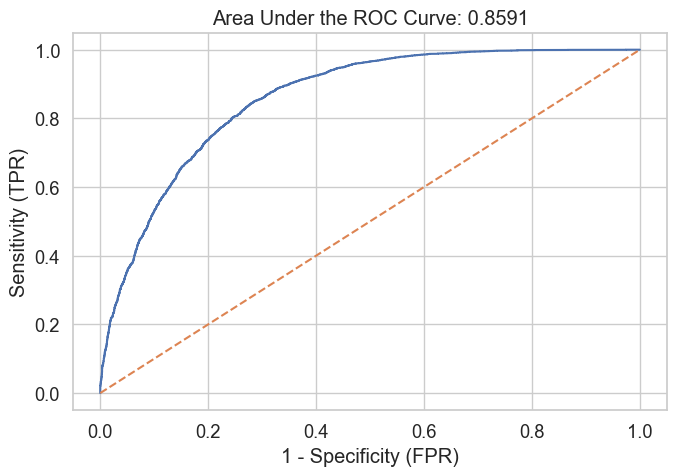

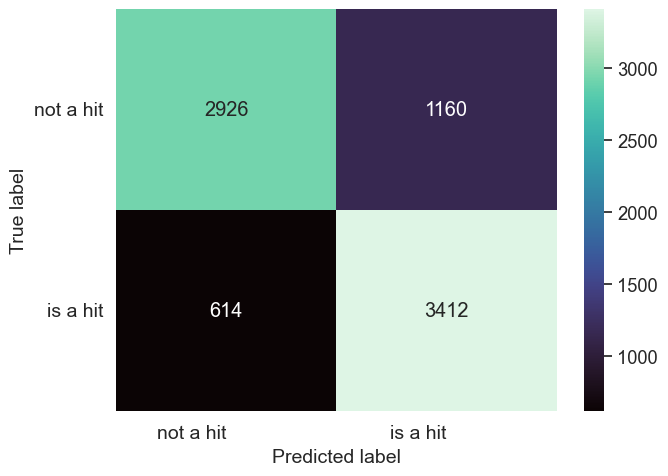

(      y_pred_prob
 0        0.411008
 1        0.592546
 2        0.550659
 3        0.033943
 4        0.587934
 ...           ...
 8107     0.705847
 8108     0.040766
 8109     0.720069
 8110     0.020291
 8111     0.804120
 
 [8112 rows x 1 columns],
       y_pred
 0          0
 1          1
 2          1
 3          0
 4          1
 ...      ...
 8107       1
 8108       0
 8109       1
 8110       0
 8111       1
 
 [8112 rows x 1 columns])

In [40]:
xgb_base = GradientBoostingClassifier()
plot_model(xgb_base, X2_train, y2_train, X2_test, y2_test)

In [41]:
# GridSearchCV For Gradient Boosting
grad = GradientBoostingClassifier()
grad_param = {'n_estimators':[100],
              'max_depth':[3,5],
              #'max_features': [6,10],
              #'min_samples_split': [None], 
              #'min_samples_leaf':[3,10],
              'learning_rate': [0.1] #0.0001, 0.001, 0.01, 
             }

grad_grid = GridSearchCV(grad, param_grid=grad_param, cv=3, scoring='f1', verbose=True, n_jobs=-1)



In [42]:
xgb1 = grad_grid.fit(X2_train,y2_train)

grad_ypred = grad_grid.predict(X2_test)

grad_yproba = grad_grid.predict_proba(X2_test)[:,1]

fpr_grad, tpr_grad, _ = roc_curve(y2_test, grad_yproba)

print('best score: ',xgb1.best_score_)
print('best params: ',xgb1.best_params_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
best score:  0.7864436795156541
best params:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [43]:
xgb2=GradientBoostingClassifier(                   
                   max_depth=3, 
                   max_features=4,
                   max_leaf_nodes=None,                   
                   #min_samples_leaf=10,
                   n_estimators=100,
                   learning_rate=0.1)
from xgboost import XGBClassifier

# xgb2=XGBClassifier(                   
#                    max_depth=3, 
#                    max_features=4,
#                    max_leaf_nodes=None,                   
#                    #min_samples_leaf=10,
#                    n_estimators=100,
#                    learning_rate=0.1)

In [44]:
xgb2b = xgb2.fit(X2_train,y2_train, )

grad_ypred = xgb2.predict(X2_test)

grad_yproba = xgb2.predict_proba(X2_test)[:,1]

fpr_grad, tpr_grad, _ = roc_curve(y2_test, grad_yproba)

The base LR accuracy is: 0.76718
The base LR f1 is: 0.78071
The base LR precision is: 0.7308
The base LR recall is: 0.83692
Precision: 0.7379, Recall: 0.8464, Accuracy: 0.7763
train error 0.8053215224124599 test error 0.7767530477396462
y pred proba  [1 0 0 ... 1 0 0]
Precision: 0.7432, Recall: 0.8423, Accuracy: 0.7772, f1: 0.7896
AUC: 0.8556


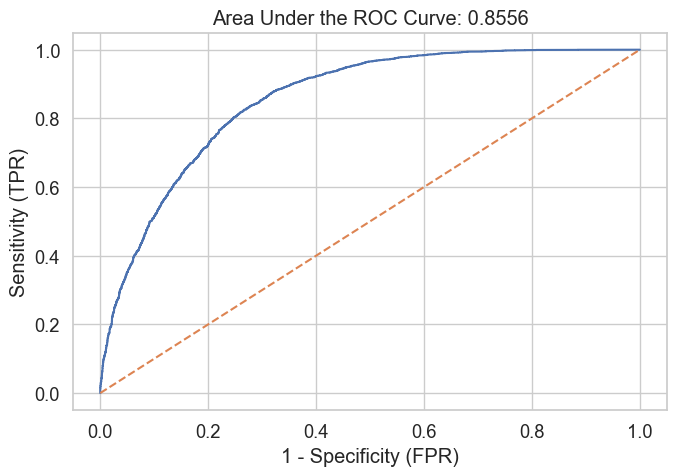

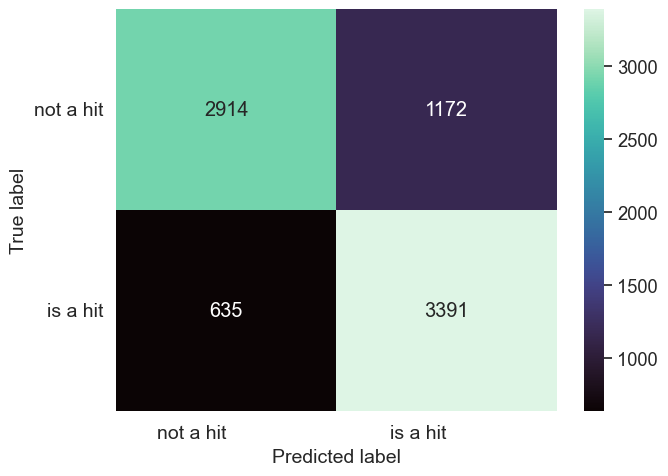

(      y_pred_prob
 0        0.419188
 1        0.586406
 2        0.610345
 3        0.060188
 4        0.612928
 ...           ...
 8107     0.713518
 8108     0.044240
 8109     0.739843
 8110     0.032255
 8111     0.804813
 
 [8112 rows x 1 columns],
       y_pred
 0          0
 1          1
 2          1
 3          0
 4          1
 ...      ...
 8107       1
 8108       0
 8109       1
 8110       0
 8111       1
 
 [8112 rows x 1 columns])

In [45]:
plot_model(xgb2, X2_train, y2_train, X2_test, y2_test)

In [46]:
# # (pd.Series(xgb2.feature_importances_, index=X.columns)
# #    .nlargest(4)
# #    .plot(kind='barh'))  
# from xgboost import plot_importance

# plot_importance(xgb2)


# importance = xgb2.feature_importances_
# feature_names = xgb2.get_booster().feature_names

# # Create a bar plot of feature importance
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(importance)), importance, tick_label=feature_names)
# plt.xticks(rotation=90)
# plt.xlabel('Feature')
# plt.ylabel('Importance')
# plt.title('Feature Importance')
# plt.tight_layout()
# plt.show()
# # import matplotlib as plt

# # def plot_variable_importance_top10(model, X_train, top_n=10):
# #     from pandas import DataFrame
# #     imp = DataFrame({"imp": model.feature_importances_, "names": X_train.columns}).sort_values("imp", ascending=True)
# #     imp_top_n = imp[-top_n:]
# #     fig, ax = plt.subplots(figsize=(imp_top_n.shape[0]/6, imp_top_n.shape[0]/5), dpi=300) 
# #     ax.barh(imp_top_n["names"], imp_top_n["imp"], color="green") 
# #    # ax.set_xlabel('\nVariable Importance')
# #    # ax.set_ylabel('Features\n') 
# #     ax.set_title('Variable Importance Plot Top 10\n') 
# #     plt.show()

# # import numpy as np
# # matplotlib.use('TkAgg')  # Set the backend to a GUI-compatible backend


# # def plot_variable_importance(model, feature_names, top_n=10):
# #     # Get feature importances from the model
# #     feature_importances = model.feature_importances_

# #     # Get the indices of the top N features based on their importance
# #     top_n_indices = np.argsort(feature_importances)[-top_n:]

# #     # Get the names of the top N features
# #     top_n_features = feature_names[top_n_indices]

# #     # Get the importance values of the top N features
# #     top_n_importances = feature_importances[top_n_indices]

# #     # Plotting the variable importance plot
# #     plt.figure(figsize=(10, 6))
# #     plt.barh(range(len(top_n_features)), top_n_importances, align='center')
# #     plt.yticks(range(len(top_n_features)), top_n_features)
# #     plt.xlabel('Importance')
# #     plt.ylabel('Features')
# #     plt.title(f'Top {top_n} Variable Importance')

# #     plt.show()  # Display the figure


The base LR accuracy is: 0.7675
The base LR f1 is: 0.78003
The base LR precision is: 0.72918
The base LR recall is: 0.83617
Precision: 0.7386, Recall: 0.8451, Accuracy: 0.7763
train error 0.8052532937104269 test error 0.7774227419505186
y pred proba  [1 0 0 ... 1 0 1]
Precision: 0.7463, Recall: 0.8418, Accuracy: 0.7795, f1: 0.7912
AUC: 0.8566


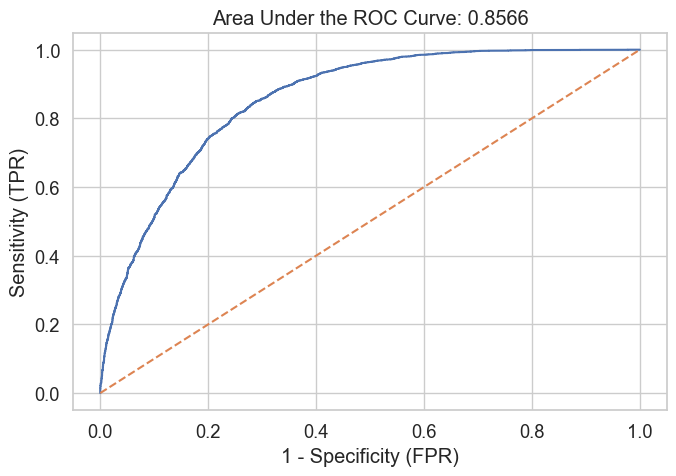

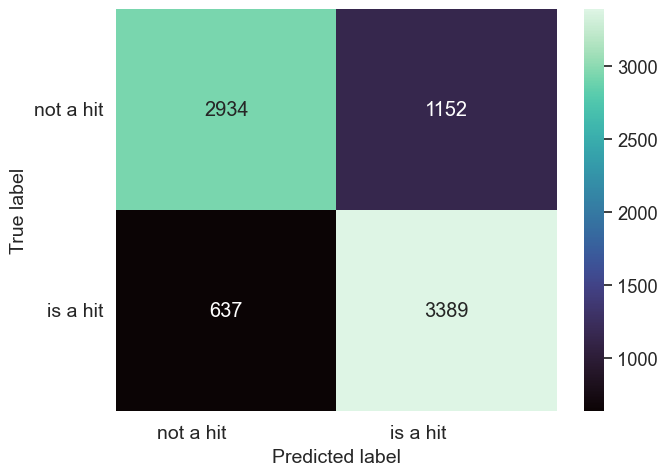

(      y_pred_prob
 0        0.443345
 1        0.611548
 2        0.573854
 3        0.035908
 4        0.531956
 ...           ...
 8107     0.721737
 8108     0.048492
 8109     0.709943
 8110     0.031947
 8111     0.827959
 
 [8112 rows x 1 columns],
       y_pred
 0          0
 1          1
 2          1
 3          0
 4          1
 ...      ...
 8107       1
 8108       0
 8109       1
 8110       0
 8111       1
 
 [8112 rows x 1 columns])

In [47]:
xgb2=GradientBoostingClassifier(                   
                   max_depth=3, 
                   max_features=4,
                   max_leaf_nodes=None,                   
                   #min_samples_leaf=10,
                   n_estimators=100,
                   learning_rate=0.1)
xgb2b = xgb2.fit(X2_train,y2_train)

grad_ypred = xgb2.predict(X2_test)

grad_yproba = xgb2.predict_proba(X2_test)[:,1]

fpr_grad, tpr_grad, _ = roc_curve(y2_test, grad_yproba)
plot_model(xgb2, X2_train, y2_train, X2_test, y2_test)


#matplotlib.use('tkAgg')
# import matplotlib.pyplot as plt
# %matplotlib inline

# feature_names = X2_train.columns

# flist2 = grad_grid.best_estimator_.feature_importances_

# std=np.std([flist2 for tree in grad_grid.best_estimator_.estimators_],axis=0)
# indices = np.argsort(flist2)[::]

# print(indices)

# ls=feature_names[indices]
# print(ls)

# # Print the feature ranking
# # print("Feature ranking:")
# for f in range(X2_train.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f] , flist2[indices[f]])) 

# # Plot the impurity-based feature importances of the forest
# ax=plt.figure(figsize=(10,6))


# #ax = fig.add_subplot(221, polar=True)    
# plt.grid(b=None)
# #plt.title("Feature importances")
# # barlist=plt.bar(range(X2_train.shape[1]), flist2[indices],
# #         color="lightblue", yerr=std[indices], align="center",alpha=0.85)

# barlist=plt.barh(range(X2_train.shape[1]),flist2[indices],
#     color="steelblue", yerr=std[indices], align="center",alpha=0.75)

# plt.yticks(range(X2_train.shape[1]), ls ,rotation=0,fontsize=16) #indices)

# plt.xticks(fontsize=12) #indices)
# plt.xlabel('Relative Score', fontsize=16)
# #plt.xlim([-1, X2_train.shape[1]])
# plt.gcf().subplots_adjust(bottom=0.15)
# plt.tight_layout()
# barlist[-1].set_color('darkorange')

# for i in range(0,5):
#     barlist[i].set_color('grey')
# #barlist[1].set_color('grey')
# plt.savefig("xg_featimportance.pdf")
# plt.show()

# X3_train = X2_train.drop(['tempo','mode','key','speechiness','energy'], axis = 1)
# X3_test = X2_test.drop(['tempo','mode','key','speechiness','energy'], axis = 1)


# columns_to_delete = ['tempo', 'mode', 'key', 'speechiness', 'energy']

# # Convert the column names to column indices
# column_indices = [column_name in X2_test.columns for column_name in columns_to_delete]

# # Use NumPy's indexing to select the desired columns and create a new ndarray without those columns
# X3_test = X2_test[:, ~np.array(column_indices)]

In [48]:
# column_names = ['tempo', 'mode', 'key', 'speechiness', 'energy']

# # Retrieve the column indices for the specified column names
# column_indices = [np.where(X2_train[0] == col_name)[0][0] for col_name in column_names]

In [49]:
# plot_variable_importance_top10(xgb2, X2_train, top_n=10)

# plot_variable_importance_top10(xgb2, X2_train, top_n=10)

REFITTING BASED ON DROPPED COLUMNS

In [50]:
# X3_train = X2_train.drop(['tempo','speechiness','energy', 'sections'], axis = 1) #mode, key to be dropped here
# X3_test = X2_test.drop(['tempo','speechiness','energy', 'sections'], axis = 1)
# rlr_secondf1 = plot_model(lr, lr_Xtrain, y2_train, X2_test, y2_test)


The base LR accuracy is: 0.76767
The base LR f1 is: 0.78156
The base LR precision is: 0.73044
The base LR recall is: 0.83592
Precision: 0.7379, Recall: 0.8465, Accuracy: 0.7763
train error 0.8054166497015652 test error 0.777189492187339
y pred proba  [1 0 0 ... 1 0 1]
Precision: 0.7482, Recall: 0.8438, Accuracy: 0.7816, f1: 0.7931
AUC: 0.8574


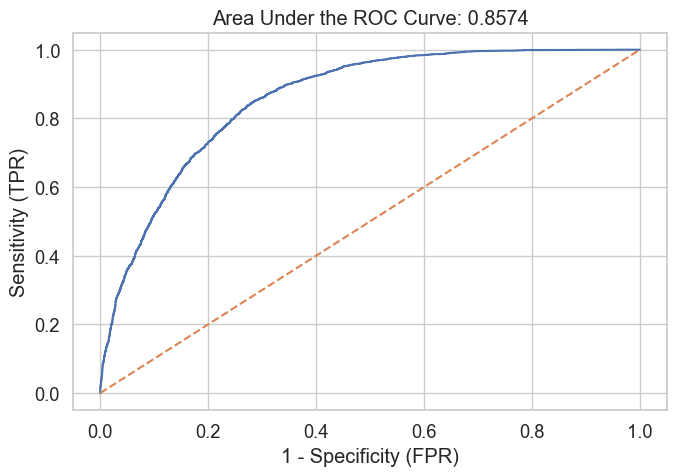

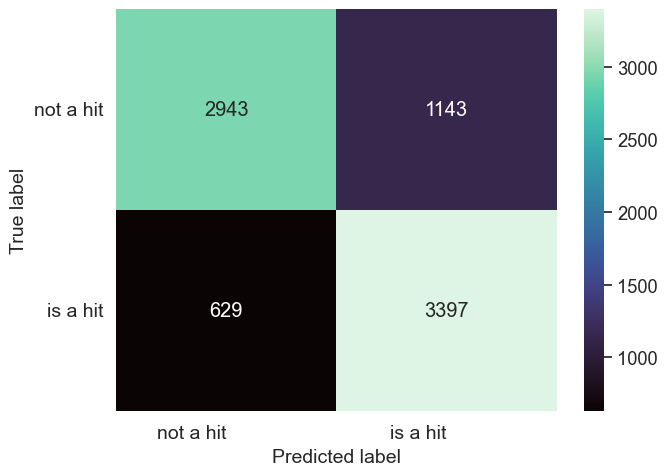

In [51]:
import pickle
# plot_model(xgb2, X3_train, y2_train, X3_test, y2_test)
# plot_model(xgb2, X2_train, y2_train, X2_test, y2_test)
pickle.dump(xgb2, open('xgb_model.pkl', 'wb'))


In [52]:
xgb_model_loaded = pickle.load(open('xgb_model.pkl', 'rb'))


In [53]:
# plot_model(xgb2, X3_train, y2_train, X3_test, y2_test, 0.66) # changing threshold to 0.66 for more precision

In [54]:
# Create DF for predicted prob/outcomes and merge back to orig df
y_pred_prob_df['row_num']= np.arange(len(y_pred_prob_df))

# y_pred_df['row_num']= np.arange(len(y_pred_df))
# X_test['row_num']= np.arange(len(X_test))
y_test_df = y_test.to_frame()
y_test_df['m_index'] = y_test_df.index
#y_test_df2=y_test_df.rename_axis('m_index')
y_test_df['row_num']= np.arange(len(y_test_df))


In [55]:
# from functools import reduce
# data_frames=[X_test,y_test_df,y_pred_df,y_pred_prob_df]
# m_results = reduce(lambda left,right: pd.merge(left,right,on=['row_num'], how='outer'),data_frames)

In [56]:
# m_results.head(10)

In [57]:
# df['m_index'] = df.index
# final_df = pd.merge(df,m_results,left_on='m_index',right_on='m_index')

In [58]:
# final_df.head()

In [59]:
# final_df.to_csv(r'sb_final_df.csv', index = False)

In [60]:
# hit_predict = xgb2.predict(X3_test) #not sure if X3_test is correct
# hit_score = xgb2.predict_proba(X3_test) #not sure if X3_test is correct
# print(f'prediction: {hit_predict[0]} \nprobability of yay: {hit_score[0][1]}\nprobability of nay: {hit_score[0][0]}')
